In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Create 2D IOR field
Input is an image where grey values map to IORs.

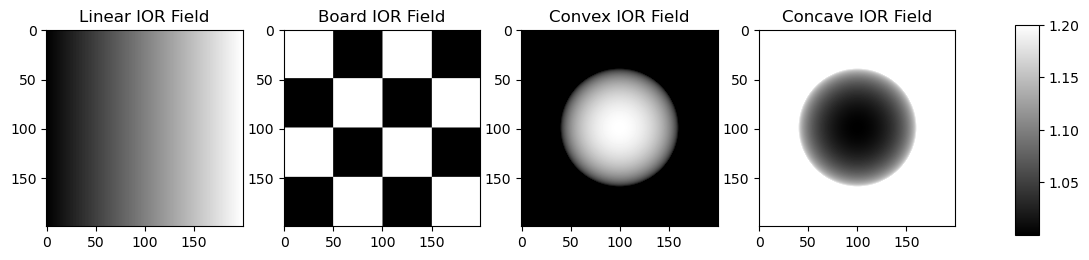

In [2]:
height, width = 200, 200
gradient = np.linspace(0, 1, width, dtype=np.float32)
linear_ior_field = np.tile(gradient, (height, 1)) * 0.2 + 1

tile_size = 50
board_ior_field = np.kron([[1, 0] * (width//tile_size//2),
                 [0, 1] * (width//tile_size//2)] * (height//tile_size//2),
                np.ones((tile_size, tile_size))) * 0.2 + 1.0

x = np.linspace(-1, 1, width)
y = np.linspace(-1, 1, height)
X, Y = np.meshgrid(x, y)
R = 0.6
r = np.sqrt(X**2 + Y**2)
n0, n1 = 1.2, 1.0
convex_lens_ior_field = n0 + (n1 - n0) * (1 - np.sqrt(1 - np.minimum(r/R, 1)**2))

n0, n1 = 1.0, 0.8
concave_lens_ior_field = n0 - (n1 - n0) * (1 - np.sqrt(1 - np.minimum(r/R, 1)**2))

plt.figure(figsize=(12, 3))
plt.subplot(141)
plt.imshow(linear_ior_field, cmap='gray')
plt.title('Linear IOR Field')
plt.subplot(142)
plt.imshow(board_ior_field, cmap='gray')
plt.title('Board IOR Field')
plt.subplot(143)
plt.imshow(convex_lens_ior_field, cmap='gray')
plt.title('Convex IOR Field')
plt.subplot(144)
plt.imshow(concave_lens_ior_field, cmap='gray')
plt.title('Concave IOR Field')

# share the same colorbar
plt.tight_layout()
plt.subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes((0.85, 0.15, 0.02, 0.7))
plt.colorbar(cax=cbar_ax)
plt.show()
# Figure 1: Different IOR fields for testing of light front propagation

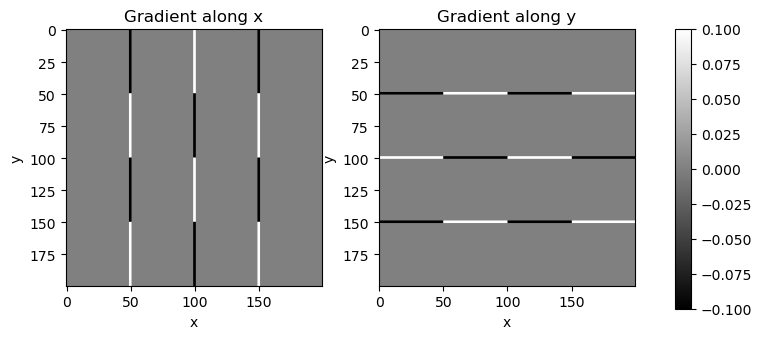

In [14]:
def compute_gradients(IOR):
    grad_x = np.gradient(IOR, axis=1)
    grad_y = np.gradient(IOR, axis=0)
    return grad_x, grad_y

grad_x, grad_y = compute_gradients(board_ior_field)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(grad_x, cmap='gray')
plt.title('Gradient along x')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(122)
plt.imshow(grad_y, cmap='gray')
plt.title('Gradient along y')

plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes((0.85, 0.15, 0.02, 0.7))
plt.colorbar(cax=cbar_ax)
plt.show()

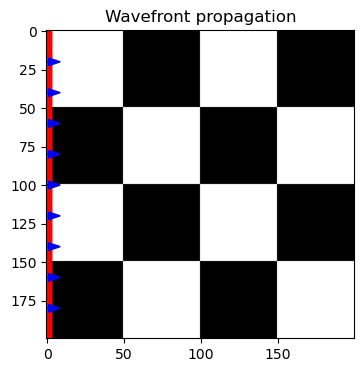

In [43]:
size = 200
initial_wavefront_positions = [(0, i) for i in range(size)]  # initial positions are on the left edge
initial_wavefront_directions = [(1, 0) for _ in range(size)]  # initial directions are all to the right

# show wavefront_positions as red dots on the IOR field and show only some of wavefront_directions as blue arrows
plt.figure(figsize=(4, 4))
plt.imshow(board_ior_field, cmap='gray')
plt.scatter([p[0] for p in initial_wavefront_positions], [p[1] for p in initial_wavefront_positions], color='red')
for i, (x, y) in enumerate(initial_wavefront_positions):
    if i != 0 and i % 20 == 0:
        plt.arrow(x, y, initial_wavefront_directions[i][0], initial_wavefront_directions[i][1], color='blue', head_width=5)
plt.title('Wavefront propagation')
plt.show()

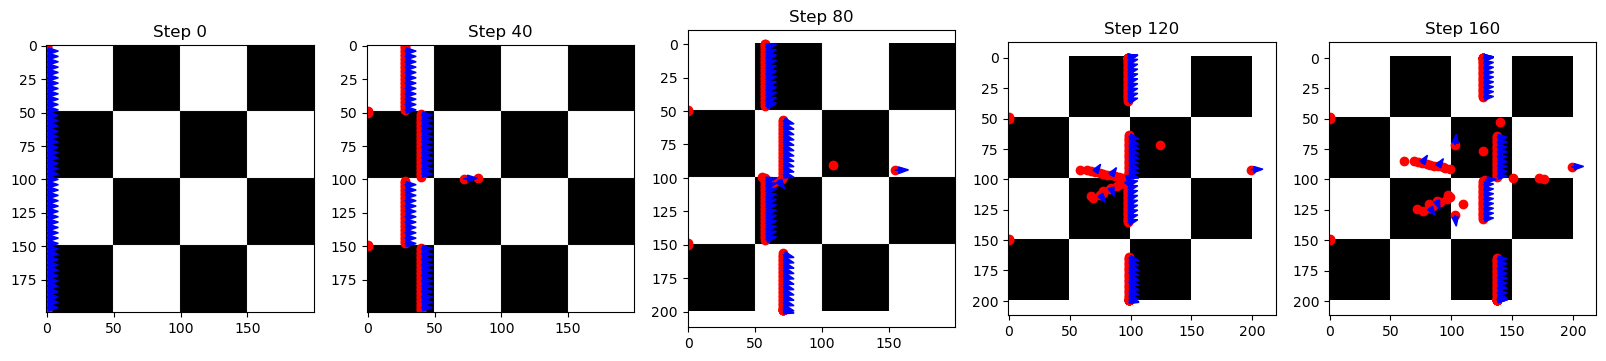

In [57]:
# x_i+1 = x_i + delta_t * v_i / n^2
# v_i+1 = v_i + delta_t * grad_n / n
def update_wavefront(pos, dir, IOR, delta_t):
    new_pos = []
    new_dir = []
    grad_x, grad_y = compute_gradients(IOR)
    for (x, y), (vx, vy) in zip(pos, dir):
        n = IOR[int(x), int(y)]
        nx = grad_x[int(x), int(y)]
        ny = grad_y[int(x), int(y)]

        # calculate the new position
        new_x = x + delta_t * (vx / (n**2))
        new_y = y + delta_t * (vy / (n**2))

        # calculate the new direction
        new_vx = vx + delta_t * (nx / n)
        new_vy = vy + delta_t * (ny / n)

        # clip the new position to the boundary
        new_x = np.clip(new_x, 0, IOR.shape[0] - 1)
        new_y = np.clip(new_y, 0, IOR.shape[1] - 1)

        new_pos.append((new_x, new_y))
        new_dir.append((new_vx, new_vy))

    return new_pos, new_dir

num_steps = 200
delta_t = 1
wavefront_pos_list = [initial_wavefront_positions]
wavefront_dir_list = [initial_wavefront_directions]

for _ in range(num_steps):
    wavefront_positions, wavefront_directions = update_wavefront(wavefront_pos_list[-1], wavefront_dir_list[-1], board_ior_field, delta_t)
    wavefront_pos_list.append(wavefront_positions)
    wavefront_dir_list.append(wavefront_directions)

num_show_images = [i for i in range(0, num_steps, num_steps // 5)]
# show the wavefront propagation in num_show_images steps between 0 and num_steps
plt.figure(figsize=(20, 4))
for i in num_show_images:
    plt.subplot(1, len(num_show_images), num_show_images.index(i) + 1)
    plt.imshow(board_ior_field, cmap='gray')
    plt.scatter([p[0] for p in wavefront_pos_list[i]], [p[1] for p in wavefront_pos_list[i]], color='red')
    for j, (x, y) in enumerate(wavefront_pos_list[i]):
        if j != 0 and j % 4 == 0:
            plt.arrow(x, y, wavefront_dir_list[i][j][0], wavefront_dir_list[i][j][1], color='blue', head_width=5)
    plt.title(f'Step {i}')
plt.show()

In [3]:
import numpy as np

# 初始位置
x, y = 0.0, 0.0

# 目标位置
target_x, target_y = 1.0, 1.0

# 步长
dx, dy = 0.1, 0.1
delta_s = np.sqrt(dx**2 + dy**2)

# 旅行时间
phi = 0.0

# 迭代计算
while x < target_x and y < target_y:
    v = 1 + 0.5 * (x**2 + y**2)
    delta_phi = delta_s / v
    phi += delta_phi
    x += dx
    y += dy

phi

1.2161974967680467

## 2. Trace a light front (from left to right)

In [ ]:
def propagate_wavefront(ior, wavefront, num_snap_shots, num_steps, step_size=0.9):
    wavefront_snapshots = []
    for step in range(num_steps):

        # TODO
        
        if step % (num_steps // num_snap_shots) == 0 or step == num_steps - 1:
            wavefront_snapshots.append(np.copy(wavefront))
    
    return wavefront_snapshots 


num_steps = 300
num_snap_shots = 7
ior_fields = [linear_ior_field, board_ior_field, convex_lens_ior_field, concave_lens_ior_field]
titles = ['Linear IOR Field', 'Board IOR Field', 'Convex Lens IOR Field', 'Concave Lens IOR Field']


plt.figure(figsize=(24, 12))
for i, ior in enumerate(ior_fields):
    wavefront = np.zeros((height, width))
    wavefront[:, 0] = 1.0
    wavefront_snapshots = propagate_wavefront(ior, wavefront, num_snap_shots, num_steps)
    for j, snapshot in enumerate(wavefront_snapshots):
        plt.subplot(len(ior_fields), len(wavefront_snapshots), i * len(wavefront_snapshots) + j + 1)
        plt.imshow(snapshot, cmap='hot', origin='lower', vmin=0, vmax=1)
        if j == 0:
            plt.colorbar()
            plt.ylabel(titles[i])
        if i == 0:
            plt.title(f'Step {j * (num_steps // num_snap_shots)}')        

plt.tight_layout()
plt.show()
# Figure 2: Propagation of light front through the different IOR fields